# aSPEM Experiment : analysis



TODO: clean-up garder blocs indep full R

TODO: moulinette statistique ? https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://en.wikipedia.org/wiki/Earth_mover%27s_distance

TODO: https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [5]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [6]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

list_suj = {'AM': 'F', 'BMC': 'M', 'CS': 'F', 'DC': 'F',
            'FM': 'F', 'IP': 'F',  'LB': 'F', 'OP': 'M',
            'RS': 'M', 'SR': 'F',  'TN': 'M', 'YK': 'M'}

In [7]:
from matplotlib.patches import Polygon


In [8]:
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=0.99, triangle=True) :
    
    
    
    if triangle is True : from matplotlib.patches import Polygon
    #fig, ax = plt.subplots(3,1,figsize=(15,20))
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    
    fig = plt.figure(figsize=(15,15))
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(6, 6)
    '''ax_ = plt.subplot(gs[1:5, :4])
    ax_x = plt.subplot(gs[0, :4])#,sharex=ax_)
    ax_y = plt.subplot(gs[1:5, 4])#,sharey=ax_)'''
    
    ax_ = plt.subplot(gs[2:5, :4])
    ax_x = plt.subplot(gs[1, :4])#,sharex=ax_)
    ax_y = plt.subplot(gs[2:5, 4])#,sharey=ax_)
    
    ax_x1= plt.subplot(gs[0, :4])#,sharex=ax_)
    ax_y1= plt.subplot(gs[2:5, 5])#,sharey=ax_)

    ax_xCum = ax_x.twinx() ; ax_xCum.tick_params('y', colors='r') ; ax_xCum.set_ylabel('H vs F',color='k')
    ax_yCum = ax_y.twiny() ; ax_yCum.tick_params('x', colors='r') ; ax_yCum.set_xlabel('H vs F',color='k')
    
    ax_x1Cum = ax_x1.twinx() ; ax_x1Cum.tick_params('y', colors='r') ; ax_x1Cum.set_ylabel('Block',color='k')
    ax_y1Cum = ax_y1.twiny() ; ax_y1Cum.tick_params('x', colors='r') ; ax_y1Cum.set_xlabel('Block',color='k')
    
    
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    #lim = (np.log(min(list_h)), np.log(max(list_h)))
    for a in [ax_x, ax_xCum, ax_x1, ax_x1Cum] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yCum, ax_y1, ax_y1Cum] : a.set_ylim(lim) ; a.set_yticks(())
    
    
    # DECO
    #---------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '--k', alpha=0.5)
    opt=dict(colors='k', linestyles='--', alpha=0.5)
    ax_.vlines(0.025, 0, 0.025, **opt) ; ax_.hlines(0.025, 0, 0.025, **opt)
    ax_.set_xlabel('$h_{va}$', fontsize=20) ; ax_.set_ylabel('$h_{bet}$', fontsize=20)
    
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    #lim = (min(list_h), max(list_h))
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    #---------------------------------------------------------------
    h_va, h_bet = {'b':[[],[],[]], 'full':[], 'F':[], 'M':[]}, {'b':[[],[],[]], 'full':[], 'F':[], 'M':[]}
    r_va, r_bet = {'b':[[],[],[]], 'full':[], 'F':[], 'M':[]}, {'b':[[],[],[]], 'full':[], 'F':[], 'M':[]}

    for num, s in enumerate(suj) :
        if list_suj[s]=='F' : coco='r'
        else :                coco='b'
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None : 
                if np.argmax(r_va_d)==len(list_h)-1 : #pourcentage
                    maxx=None
                    for round_ in list(reversed(np.arange(5))) :
                        if maxx is None :
                            for x in range(len(r_va_d)) :
                                if np.round(r_va_d[x], round_)==np.round(pourcentage*np.max(r_va_d), round_) :
                                    maxx=x

                    r_va_s.append(r_va_d[maxx])
                    h_va_s.append(list_h[maxx])
                else :
                    r_va_s.append(np.max(r_va_d))
                    h_va_s.append(list_h[np.argmax(r_va_d)])

                if np.argmax(r_bet_d)==len(list_h)-1 : #pourcentage
                    maxx=None
                    for round_ in list(reversed(np.arange(5))) :
                        if maxx is None :
                            for x in range(len(r_bet_d)) :
                                if np.round(r_bet_d[x], round_)==np.round(pourcentage*np.max(r_bet_d), round_) :
                                    maxx=x

                    r_bet_s.append(r_bet_d[maxx])
                    h_bet_s.append(list_h[maxx])
                else :
                    r_bet_s.append(np.max(r_bet_d))
                    h_bet_s.append(list_h[np.argmax(r_bet_d)])
            else :
                r_va_s.append(np.max(r_va_d))
                h_va_s.append(list_h[np.argmax(r_va_d)])
                r_bet_s.append(np.max(r_bet_d))
                h_bet_s.append(list_h[np.argmax(r_bet_d)])
                

            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        if triangle is True :
            baba = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
            #poly = Polygon(baba, color=COLOR[num], alpha=0.3, lw=2)
            poly = Polygon(baba, edgecolor=coco, alpha=0.5, lw=1.5, facecolor='none')
            ax_.add_artist(poly)
                    
        #opt = dict(c=COLOR[num], alpha=0.5, lw=3, edgecolors=coco,)
        opt = dict(alpha=0.5, lw=0, edgecolors=coco,)
        ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*400,
                    marker='*' if s in ['TN', 'LB'] else None,
                    zorder=100  if s in ['TN', 'LB'] else 50, c='g', **opt)
        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*400,
                    c=['y', 'r'], zorder=50, **opt)

        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)

        h_va[list_suj[s]].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
        h_bet[list_suj[s]].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
        r_va[list_suj[s]].extend(r_va_s)
        r_bet[list_suj[s]].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])


    axis_r = [min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100,
              min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100]
    
    
    #-------------------------------------------------------------------------------------
    range_his = (np.log(min(list_h)), np.log(max(list_h)))
    bins_his=20

    opt = dict(range=range_his, bins=bins_his, alpha=0.3)
    ax_x.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt)
    ax_x.hist([np.log(h_va['F']), np.log(h_va['M'])], weights=[r_va['F'], r_va['M']], color=['r', 'b'], **opt)
    
    ax_x1.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt)
    ax_x1.hist([np.log(h_va['b'][0]), np.log(h_va['b'][1]), np.log(h_va['b'][2])],
               weights=[r_va['b'][0], r_va['b'][1], r_va['b'][2]],
               color=['g', 'y', 'r'], **opt)
    

    opt['orientation'] = "horizontal"
    ax_y.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt)
    ax_y.hist([np.log(h_bet['F']), np.log(h_bet['M'])],weights=[r_bet['F'], r_bet['M']], color=['r', 'b'],  **opt)

    
    ax_y1.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt)
    ax_y1.hist([np.log(h_bet['b'][0]), np.log(h_bet['b'][1]), np.log(h_bet['b'][2])],
               weights=[r_bet['b'][0], r_bet['b'][1], r_bet['b'][2]],
               color=['g', 'y', 'r'], **opt)
    
    
    
    range_his = (np.log(min(list_h)-min(list_h)/9), np.log(max(list_h)+max(list_h)/9))
    bins_his=len(list_h)
    #{'bar', 'barstacked', 'step',  'stepfilled'}
    opt_cum = dict(range=range_his, bins=bins_his, cumulative=True, histtype='step',
                   align='mid', lw=1.5, density=True)
    ax_xCum.hist([np.log(h_va['full']), np.log(h_va['F']), np.log(h_va['M'])],
                 weights=[r_va['full'], r_va['F'], r_va['M']], color=['k', 'r', 'b'],  **opt_cum)
    ax_x1Cum.hist([np.log(h_va['full']), np.log(h_va['b'][0]), np.log(h_va['b'][1]), np.log(h_va['b'][2])],
                 weights=[r_va['full'], r_va['b'][0], r_va['b'][1], r_va['b'][2]],
                  color=['k', 'g', 'y', 'r'], **opt_cum)
    
    opt_cum['orientation'] = "horizontal"
    ax_yCum.hist([np.log(h_bet['full']), np.log(h_bet['F']), np.log(h_bet['M'])],
                 weights=[r_bet['full'], r_bet['F'], r_bet['M']], color=['k', 'r', 'b'], **opt_cum)
    ax_y1Cum.hist([np.log(h_bet['full']), np.log(h_bet['b'][0]), np.log(h_bet['b'][1]), np.log(h_bet['b'][2])],
                 weights=[r_bet['full'], r_bet['b'][0], r_bet['b'][1], r_bet['b'][2]],
                  color=['k', 'g', 'y', 'r'], **opt_cum)
    
    
    opt=dict(colors='r', linestyles='--', alpha=0.5)
    from scipy import stats
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*70,'\n%s\n'%title, '-'*70, sep='')
        
        print('\nH vs F', end=' -> ')
        print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h['F'], h['M']).pvalue,
              'kruskal=%.4f'%stats.kruskal(h['F'], h['M']).pvalue,
              'ks_2samp=%.4f'%stats.ks_2samp(h['F'], h['M']).pvalue, sep='  ')
              #'\nwasserstein_distance (Earth movers distance) : ',
              #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
               
        for b1 in range(2) :
            for b2 in range(1, 3) :
                if b1!=b2 :
                    print('BLOCK %s vs %s'%(b1,b2), end=' -> ')
                    print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h['b'][b1], h['b'][b2]).pvalue,
                          'kruskal=%.4f'%stats.kruskal(h['b'][b1], h['b'][b2]).pvalue,
                          'ks_2samp=%.4f'%stats.ks_2samp(h['b'][b1], h['b'][b2]).pvalue, sep='  ')
                    
        
        for c in coupe :
            print('\n\nCoupe à h=%s, tau=%s\n'%(c, 1/c), '-'*30, sep='')
            ax_.vlines(c, 0, 10, **opt) ; ax_.hlines(c, 0, 10, **opt)
            
            for h_g, r_g in zip([h['F'], h['M']], [r['F'], r['M']]) :
                g=0
                while g < len(h_g) :
                    if h_g[g] < c : del h_g[g] ; del r_g[g]
                    else :          g=g+1

            print('\nH vs F', end=' -> ')
            print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h['F'], h['M']).pvalue,
                  'kruskal=%.4f'%stats.kruskal(h['F'], h['M']).pvalue,
                  'ks_2samp=%.4f'%stats.ks_2samp(h['F'], h['M']).pvalue, sep='  ')
           
            for h_g in [h['b'][0], h['b'][1], h['b'][2]] :
                g=0
                while g < len(h_g) :
                    if h_g[g] < c : del h_g[g]
                    else :          g=g+1

            for b1 in range(2) :
                for b2 in range(1, 3) :
                    if b1!=b2 :
                        print('BLOCK %s vs %s'%(b1,b2), end=' -> ')
                        print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h['b'][b1], h['b'][b2]).pvalue,
                              'kruskal=%.4f'%stats.kruskal(h['b'][b1], h['b'][b2]).pvalue,
                              'ks_2samp=%.4f'%stats.ks_2samp(h['b'][b1], h['b'][b2]).pvalue, sep='  ')
    
    plt.show()
    return fig

AM BMC CS DC FM IP LB OP RS SR TN YK 

----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.1756  kruskal=0.3430  ks_2samp=0.2886
BLOCK 0 vs 1 -> mannwhitneyu=0.4654  kruskal=0.9078  ks_2samp=0.9985
BLOCK 0 vs 2 -> mannwhitneyu=0.0214  kruskal=0.0400  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.0200  kruskal=0.0373  ks_2samp=0.0995


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.1039  kruskal=0.2013  ks_2samp=0.1920
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.9992
BLOCK 0 vs 2 -> mannwhitneyu=0.0024  kruskal=0.0042  ks_2samp=0.0112
BLOCK 1 vs 2 -> mannwhitneyu=0.0008  kruskal=0.0015  ks_2samp=0.0067


Coupe à h=0.005, tau=200.0
------------------------------

H vs F -> mannwhitneyu=0.1039  kruskal=0.2013  ks_2samp=0.1920
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.9992
BLOCK 0 vs 2 -> man

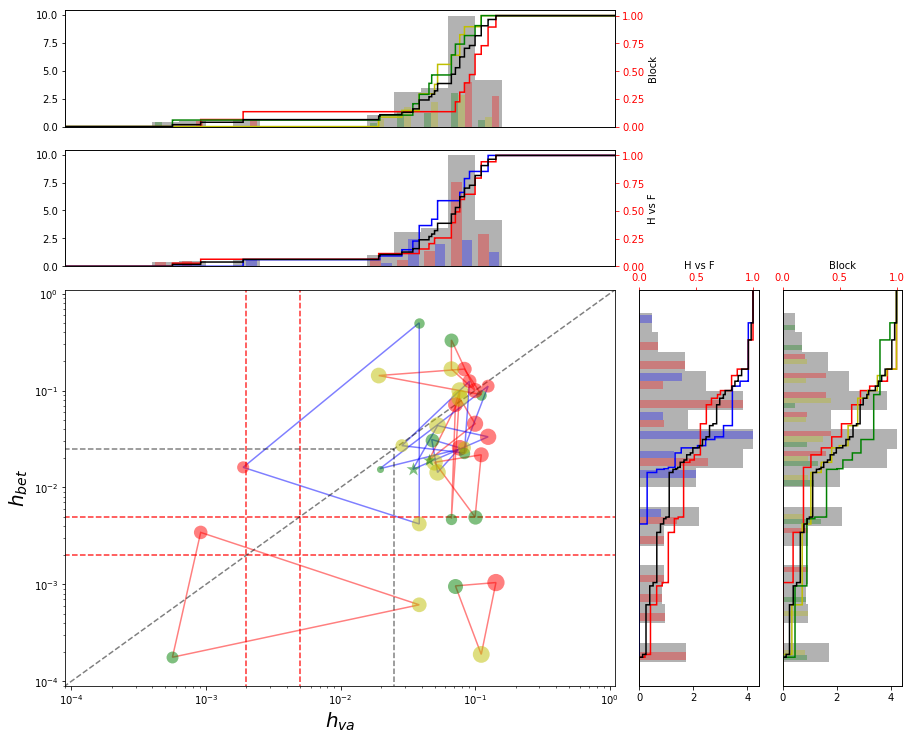

In [9]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

AM BMC CS DC FM IP LB OP RS SR TN YK 

----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.4807  kruskal=0.9485  ks_2samp=0.9999
BLOCK 0 vs 1 -> mannwhitneyu=0.2905  kruskal=0.5613  ks_2samp=0.9985
BLOCK 0 vs 2 -> mannwhitneyu=0.0550  kruskal=0.1038  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.1282  kruskal=0.2444  ks_2samp=0.2558


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.4562  kruskal=0.8978  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4141  kruskal=0.8042  ks_2samp=0.9932
BLOCK 0 vs 2 -> mannwhitneyu=0.0104  kruskal=0.0190  ks_2samp=0.0303
BLOCK 1 vs 2 -> mannwhitneyu=0.0179  kruskal=0.0330  ks_2samp=0.0617


Coupe à h=0.005, tau=200.0
------------------------------

H vs F -> mannwhitneyu=0.4562  kruskal=0.8978  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4141  kruskal=0.8042  ks_2samp=0.9932
BLOCK 0 vs 2 -> man

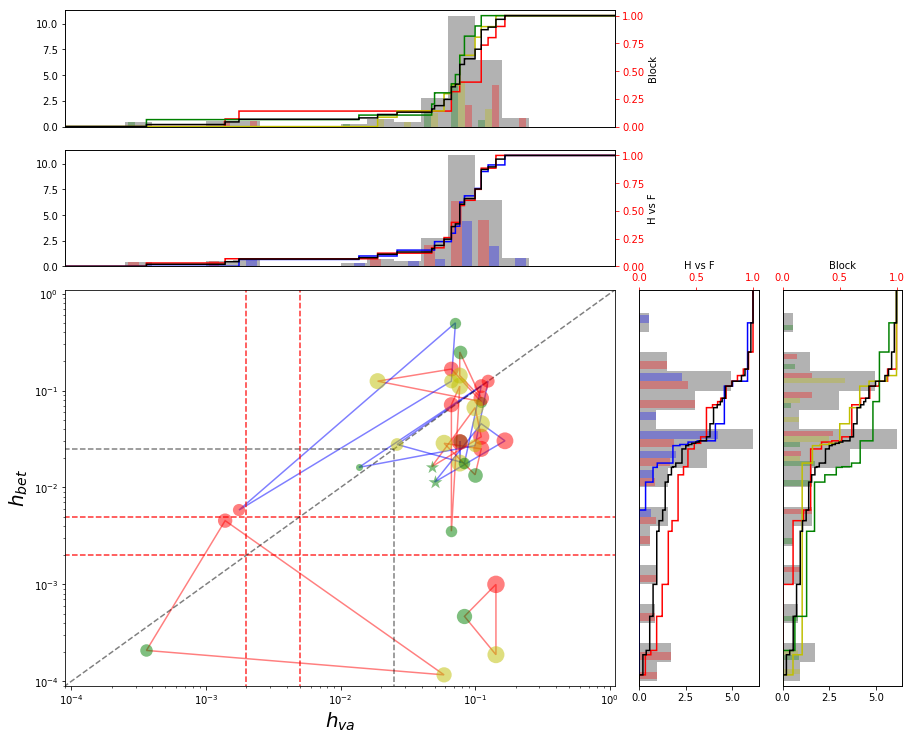

In [10]:
file = os.path.join('parametre', 'list_h_block_Scalling_sujet.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

AM BMC CS DC FM IP LB OP RS SR TN YK 

----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.4297  kruskal=0.8468  ks_2samp=0.9996
BLOCK 0 vs 1 -> mannwhitneyu=0.2912  kruskal=0.5628  ks_2samp=0.8690
BLOCK 0 vs 2 -> mannwhitneyu=0.0520  kruskal=0.0979  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.1764  kruskal=0.3379  ks_2samp=0.5361


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.5000  kruskal=0.9854  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.7771
BLOCK 0 vs 2 -> mannwhitneyu=0.0095  kruskal=0.0173  ks_2samp=0.0303
BLOCK 1 vs 2 -> mannwhitneyu=0.0314  kruskal=0.0583  ks_2samp=0.1342


Coupe à h=0.005, tau=200.0
------------------------------

H vs F -> mannwhitneyu=0.5000  kruskal=0.9854  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.7771
BLOCK 0 vs 2 -> man

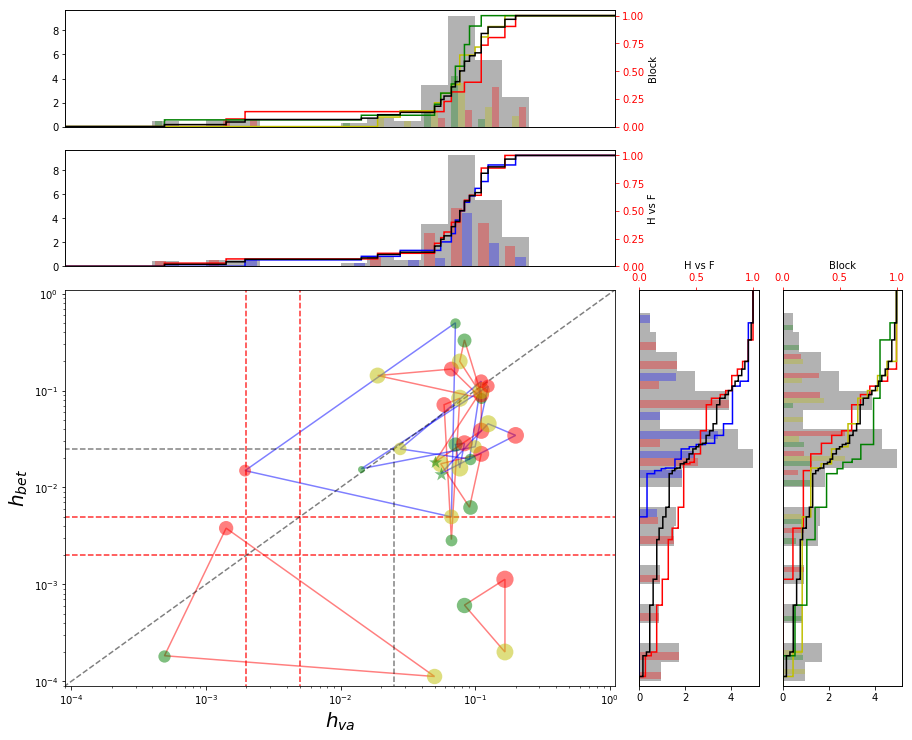

In [11]:
file = os.path.join('parametre', 'list_h_block_Scalling_full.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])